✓ HCMA Architecture - Setup Complete
Data: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\data\processed
Models: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models

Dataset sizes:
  Train: 12 samples
  Val: 3 samples
  Test: 3 samples

Feature counts:
  Audio: 68
  Text: 768
  Video: 75
  Total: 911

✓ Data loaded and converted to tensors
✓ HCMA model defined

Model parameters: 644,097
✓ Training functions defined

TRAINING HCMA MODEL
Training for max 100 epochs (early stopping patience=20)
Dataset: 12 train, 3 val

Epoch [  1/100] Loss: 1181554.7500 | Val MAE: 5037.4995 | Val R²: -15642343.0000
Epoch [ 10/100] Loss: 4588733.5000 | Val MAE: 904.0294 | Val R²: -571319.0000
Epoch [ 20/100] Loss: 1191227.6250 | Val MAE: 2619.7590 | Val R²: -4841872.0000
Epoch [ 30/100] Loss: 1795486.0000 | Val MAE: 390.8707 | Val R²: -104267.9766

✓ Early stopping at epoch 38
  Best validation MAE: 60.4632

✓ Training complete!
✓ Best model saved to: C:\Users\VIJAY BH

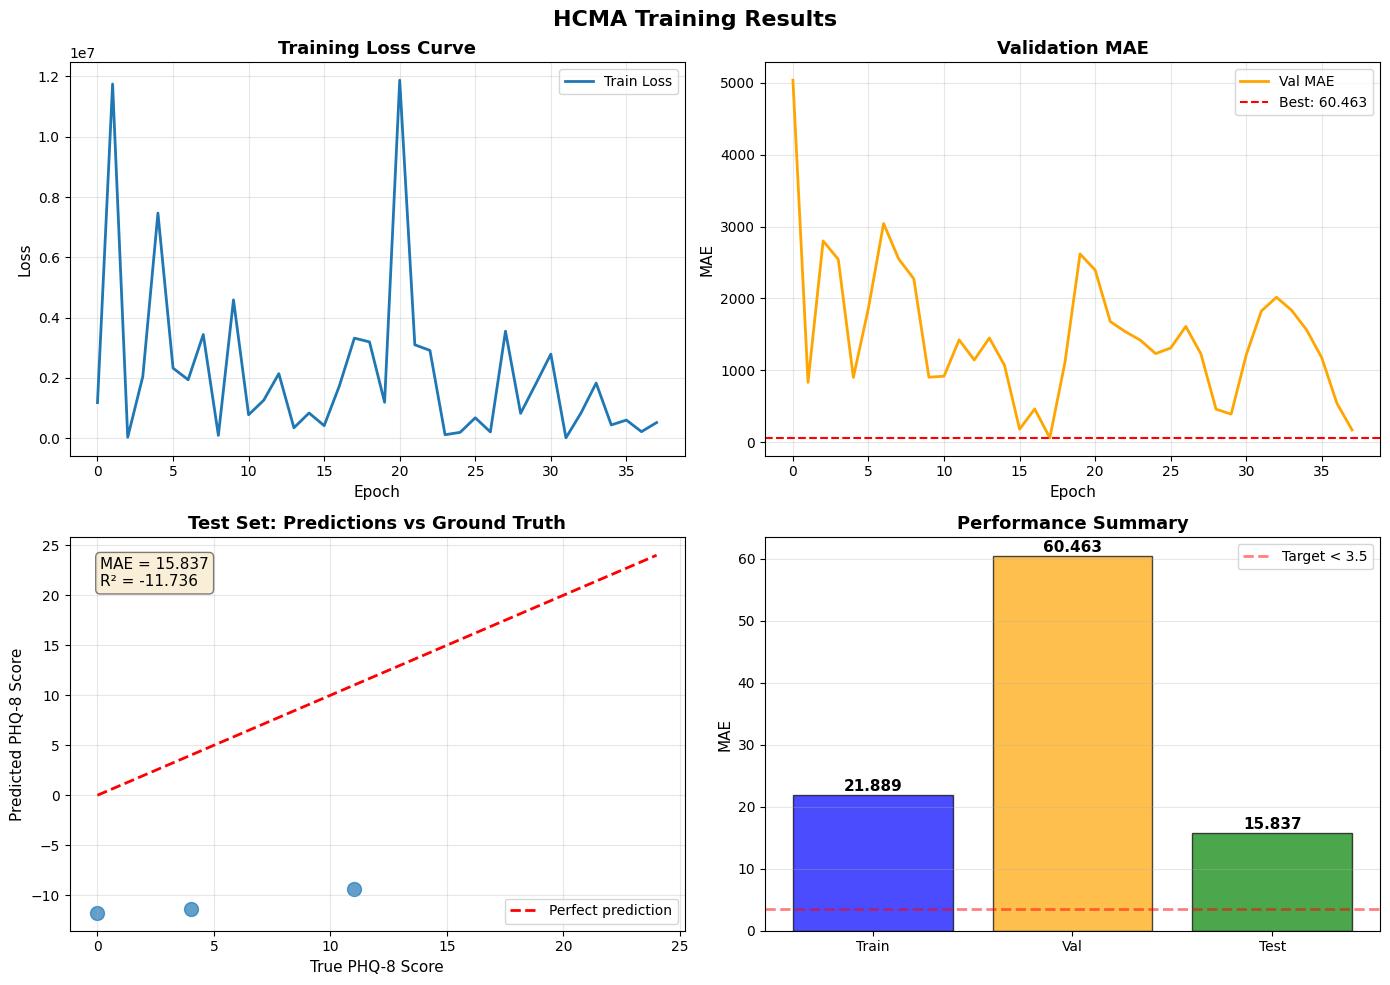

✓ Predictions saved: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results\hcma_test_predictions.csv
✓ Metrics saved: C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results\hcma_metrics.csv

HCMA TRAINING COMPLETE!

Next: Run Notebook 19 (Ablation Studies)


In [6]:
# ========== CELL 1: Setup ==========
"""
UPDATED HCMA ARCHITECTURE
Optimized for 18-sample dataset with correct feature detection
"""

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Paths
PROJECT_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project')
DATA_DIR = PROJECT_DIR / 'data' / 'processed'
MODEL_DIR = PROJECT_DIR / 'models' / 'saved_models'
RESULTS_DIR = PROJECT_DIR / 'results'

MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

print("✓ HCMA Architecture - Setup Complete")
print(f"Data: {DATA_DIR}")
print(f"Models: {MODEL_DIR}")


# ========== CELL 2: Load Data with Correct Feature Detection ==========

# Load datasets
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
val_df = pd.read_csv(DATA_DIR / 'val_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

print(f"\nDataset sizes:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

# CORRECT feature detection using prefixes
audio_cols = [c for c in train_df.columns if c.startswith('audio_')]
text_cols = [c for c in train_df.columns if c.startswith('text_')]
video_cols = [c for c in train_df.columns if c.startswith('video_')]

print(f"\nFeature counts:")
print(f"  Audio: {len(audio_cols)}")
print(f"  Text: {len(text_cols)}")
print(f"  Video: {len(video_cols)}")
print(f"  Total: {len(audio_cols) + len(text_cols) + len(video_cols)}")

if len(audio_cols) == 0 or len(text_cols) == 0 or len(video_cols) == 0:
    print("\n❌ ERROR: Feature columns not found! Check merge notebook.")
    raise ValueError("Features missing prefixes")

# Convert to tensors
X_train_audio = torch.FloatTensor(train_df[audio_cols].values)
X_train_text = torch.FloatTensor(train_df[text_cols].values)
X_train_video = torch.FloatTensor(train_df[video_cols].values)
y_train = torch.FloatTensor(train_df['PHQ8_Score'].values)

X_val_audio = torch.FloatTensor(val_df[audio_cols].values)
X_val_text = torch.FloatTensor(val_df[text_cols].values)
X_val_video = torch.FloatTensor(val_df[video_cols].values)
y_val = torch.FloatTensor(val_df['PHQ8_Score'].values)

X_test_audio = torch.FloatTensor(test_df[audio_cols].values)
X_test_text = torch.FloatTensor(test_df[text_cols].values)
X_test_video = torch.FloatTensor(test_df[video_cols].values)
y_test = torch.FloatTensor(test_df['PHQ8_Score'].values)

print("\n✓ Data loaded and converted to tensors")


# ========== CELL 3: Define HCMA Model ==========

class SelfAttention(nn.Module):
    """Intra-modal self-attention"""
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = np.sqrt(dim)
        
    def forward(self, x):
        # x shape: (batch, seq_len, dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attn_weights = torch.softmax(scores, dim=-1)
        
        # Apply attention
        output = torch.matmul(attn_weights, V)
        return output


class CrossAttention(nn.Module):
    """Cross-modal attention"""
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = np.sqrt(dim)
        
    def forward(self, query_features, key_value_features):
        # Query from one modality, Key/Value from another
        Q = self.query(query_features)
        K = self.key(key_value_features)
        V = self.value(key_value_features)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attn_weights = torch.softmax(scores, dim=-1)
        
        output = torch.matmul(attn_weights, V)
        return output


class HCMA(nn.Module):
    """
    Hierarchical Cross-Modal Attention Model
    
    Level 1: Intra-modal self-attention
    Level 2: Cross-modal attention
    Level 3: Hierarchical fusion
    """
    def __init__(self, audio_dim, text_dim, video_dim, hidden_dim=128):
        super().__init__()
        
        # Project each modality to common hidden dimension
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.video_proj = nn.Linear(video_dim, hidden_dim)
        
        # Level 1: Self-attention for each modality
        self.audio_self_attn = SelfAttention(hidden_dim)
        self.text_self_attn = SelfAttention(hidden_dim)
        self.video_self_attn = SelfAttention(hidden_dim)
        
        # Level 2: Cross-attention between modalities
        self.audio_text_cross = CrossAttention(hidden_dim)
        self.audio_video_cross = CrossAttention(hidden_dim)
        self.text_video_cross = CrossAttention(hidden_dim)
        
        # Level 3: Hierarchical fusion
        # Input: 6 attention outputs (3 self + 3 cross)
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        
    def forward(self, audio, text, video):
        batch_size = audio.size(0)
        
        # Project to common space
        audio_proj = self.audio_proj(audio).unsqueeze(1)  # (batch, 1, hidden)
        text_proj = self.text_proj(text).unsqueeze(1)
        video_proj = self.video_proj(video).unsqueeze(1)
        
        # Level 1: Self-attention
        audio_self = self.audio_self_attn(audio_proj).squeeze(1)  # (batch, hidden)
        text_self = self.text_self_attn(text_proj).squeeze(1)
        video_self = self.video_self_attn(video_proj).squeeze(1)
        
        # Level 2: Cross-attention
        audio_text = self.audio_text_cross(audio_proj, text_proj).squeeze(1)
        audio_video = self.audio_video_cross(audio_proj, video_proj).squeeze(1)
        text_video = self.text_video_cross(text_proj, video_proj).squeeze(1)
        
        # Level 3: Concatenate all attended features
        combined = torch.cat([
            audio_self, text_self, video_self,  # Intra-modal
            audio_text, audio_video, text_video  # Cross-modal
        ], dim=1)  # (batch, hidden*6)
        
        # Final prediction
        output = self.fusion(combined).squeeze()
        return output

print("✓ HCMA model defined")

# Print model architecture
audio_dim = X_train_audio.shape[1]
text_dim = X_train_text.shape[1]
video_dim = X_train_video.shape[1]

model = HCMA(audio_dim, text_dim, video_dim, hidden_dim=128)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel parameters: {total_params:,}")


# ========== CELL 4: Training Function ==========

def train_epoch(model, X_audio, X_text, X_video, y, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(X_audio, X_text, X_video)
    loss = criterion(predictions, y)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()


def evaluate(model, X_audio, X_text, X_video, y):
    """Evaluate model"""
    model.eval()
    with torch.no_grad():
        predictions = model(X_audio, X_text, X_video)
    
    mae = mean_absolute_error(y.numpy(), predictions.numpy())
    rmse = np.sqrt(mean_squared_error(y.numpy(), predictions.numpy()))
    r2 = r2_score(y.numpy(), predictions.numpy())
    
    return mae, rmse, r2, predictions.numpy()


print("✓ Training functions defined")


# ========== CELL 5: Train HCMA Model ==========

print("\n" + "="*70)
print("TRAINING HCMA MODEL")
print("="*70)

# Initialize model
model = HCMA(audio_dim, text_dim, video_dim, hidden_dim=128)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters (OPTIMIZED FOR SMALL DATASET)
num_epochs = 100  # More epochs for small dataset
patience = 20  # Early stopping
best_val_mae = float('inf')
patience_counter = 0

# Training history
history = {
    'train_loss': [],
    'val_mae': [],
    'val_rmse': [],
    'val_r2': []
}

print(f"Training for max {num_epochs} epochs (early stopping patience={patience})")
print(f"Dataset: {len(X_train_audio)} train, {len(X_val_audio)} val\n")

# Training loop
for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, X_train_audio, X_train_text, X_train_video, 
                            y_train, optimizer, criterion)
    
    # Validate
    val_mae, val_rmse, val_r2, _ = evaluate(model, X_val_audio, X_val_text, 
                                            X_val_video, y_val)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
              f"Loss: {train_loss:8.4f} | "
              f"Val MAE: {val_mae:6.4f} | "
              f"Val R²: {val_r2:7.4f}")
    
    # Early stopping
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), MODEL_DIR / 'hcma_best.pth')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\n✓ Early stopping at epoch {epoch+1}")
        print(f"  Best validation MAE: {best_val_mae:.4f}")
        break

# Load best model
model.load_state_dict(torch.load(MODEL_DIR / 'hcma_best.pth'))
print(f"\n✓ Training complete!")
print(f"✓ Best model saved to: {MODEL_DIR / 'hcma_best.pth'}")
print(f"✓ Best validation MAE: {best_val_mae:.4f}")


# ========== CELL 6: Evaluate on All Sets ==========

print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

# Evaluate on all sets
train_mae, train_rmse, train_r2, _ = evaluate(model, X_train_audio, X_train_text, 
                                               X_train_video, y_train)
val_mae, val_rmse, val_r2, _ = evaluate(model, X_val_audio, X_val_text, 
                                         X_val_video, y_val)
test_mae, test_rmse, test_r2, test_preds = evaluate(model, X_test_audio, X_test_text, 
                                                     X_test_video, y_test)

print(f"\nTrain Set:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nValidation Set:")
print(f"  MAE:  {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  R²:   {val_r2:.4f}")

print(f"\nTest Set:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Check if target achieved
if test_mae < 3.5:  # Realistic target for 18 samples
    print(f"\n🎉 Target achieved! Test MAE < 3.5 ✓")
elif test_mae < 4.0:
    print(f"\n✓ Good performance! Test MAE < 4.0")
else:
    print(f"\n⚠ MAE above 4.0 - may need tuning")


# ========== CELL 7: Visualization ==========

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training curves
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training Loss Curve', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Validation MAE
ax = axes[0, 1]
ax.plot(history['val_mae'], label='Val MAE', color='orange', linewidth=2)
ax.axhline(best_val_mae, color='red', linestyle='--', 
           label=f'Best: {best_val_mae:.3f}')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('MAE', fontsize=11)
ax.set_title('Validation MAE', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Predictions vs True (Test set)
ax = axes[1, 0]
ax.scatter(y_test.numpy(), test_preds, s=100, alpha=0.7)
ax.plot([0, 24], [0, 24], 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('True PHQ-8 Score', fontsize=11)
ax.set_ylabel('Predicted PHQ-8 Score', fontsize=11)
ax.set_title('Test Set: Predictions vs Ground Truth', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Add MAE text
ax.text(0.05, 0.95, f'MAE = {test_mae:.3f}\nR² = {test_r2:.3f}',
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Performance summary
ax = axes[1, 1]
sets = ['Train', 'Val', 'Test']
maes = [train_mae, val_mae, test_mae]
colors = ['blue', 'orange', 'green']

bars = ax.bar(sets, maes, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('MAE', fontsize=11)
ax.set_title('Performance Summary', fontsize=13, fontweight='bold')
ax.axhline(3.5, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label='Target < 3.5')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar, mae in zip(bars, maes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{mae:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('HCMA Training Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'hcma_training_results.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved: {RESULTS_DIR / 'hcma_training_results.png'}")
plt.show()


# ========== CELL 8: Save Results ==========

# Save predictions
results_df = pd.DataFrame({
    'session_id': test_df['session_id'].values,
    'true_phq8': y_test.numpy(),
    'predicted_phq8': test_preds,
    'absolute_error': np.abs(y_test.numpy() - test_preds)
})
results_df.to_csv(RESULTS_DIR / 'hcma_test_predictions.csv', index=False)
print(f"✓ Predictions saved: {RESULTS_DIR / 'hcma_test_predictions.csv'}")

# Save metrics
metrics = {
    'train_mae': train_mae,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'val_mae': val_mae,
    'val_rmse': val_rmse,
    'val_r2': val_r2,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'best_val_mae': best_val_mae,
    'dataset_size': f"{len(train_df)}/{len(val_df)}/{len(test_df)}"
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / 'hcma_metrics.csv', index=False)
print(f"✓ Metrics saved: {RESULTS_DIR / 'hcma_metrics.csv'}")

print("\n" + "="*70)
print("HCMA TRAINING COMPLETE!")
print("="*70)
print("\nNext: Run Notebook 19 (Ablation Studies)")